#### 이 대회 핵심은, 주어진 과거 데이터를 통해
#### 총 14일(14*24 = 336시간) 미래 336시간 적산차 변화를 예측하여
#### 평가 기준 MAE(평균절대오차) 으로 순위를 매긴다.
#### MAE는 값이 작을수록 예측값과 실제값이 차이가 없음
#### 즉, MAE를 낮추도록 설계해야하는것이 포인트.

# [라이브러리 불러오기]

In [204]:
#import
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
from tqdm.auto import tqdm
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from keras import layers

import warnings
import pandas as pd
from tqdm.auto import tqdm

# 쓸데없는 경고문 출력 끄기
warnings.filterwarnings(action="ignore")

# [데이터 불러오기]

In [205]:
# csv파일 변수에 담기
train_data = pd.read_csv("data_tr_city.csv")
test_data = pd.read_csv("data_ts_city.csv")

In [206]:
train_data

,datetime,구미 혁신도시배수지 유출유량 적산차
0,2017-01-01 01:00:00,138.0
1,2017-01-01 02:00:00,237.0
2,2017-01-01 03:00:00,128.0
3,2017-01-01 04:00:00,14.0
4,2017-01-01 05:00:00,11.0
...,...,...
35058,2020-12-31 19:00:00,328.0
35059,2020-12-31 20:00:00,347.0
35060,2020-12-31 21:00:00,335.0
35061,2020-12-31 22:00:00,141.0




일단 현재 train_data가 날짜 형식이 아닌 그냥 갯수 숫자로 지정되어 있는데,
분석을 위해 인덱스를 날짜 형식으로 변환
'datetime' 칼럼에 날짜 정보가 있으므로 이를 활용
인덱스를 datetime 값으로 변경 후 인덱스로 지정. 그리고 datetime 칼럼 삭제
칼럼이 '구미 혁신도시배수지 유출유량 적산차' 로 되어있으므로 이를 보기 쉽게 적당히 'value'로 변환

In [207]:
train_data.index

RangeIndex(start=0, stop=35063, step=1)

In [208]:
train_data.index = pd.to_datetime(train_data["datetime"], format="%Y-%m-%d %H:%M:%S")

In [209]:
train_data

,datetime,구미 혁신도시배수지 유출유량 적산차
datetime,,
2017-01-01 01:00:00,2017-01-01 01:00:00,138.0
2017-01-01 02:00:00,2017-01-01 02:00:00,237.0
2017-01-01 03:00:00,2017-01-01 03:00:00,128.0
2017-01-01 04:00:00,2017-01-01 04:00:00,14.0
2017-01-01 05:00:00,2017-01-01 05:00:00,11.0
...,...,...
2020-12-31 19:00:00,2020-12-31 19:00:00,328.0
2020-12-31 20:00:00,2020-12-31 20:00:00,347.0
2020-12-31 21:00:00,2020-12-31 21:00:00,335.0


In [210]:
# datetime 칼럼 삭제
train_data = train_data.drop(columns = 'datetime')
train_data.columns = ['value']
train_data

,value
datetime,
2017-01-01 01:00:00,138.0
2017-01-01 02:00:00,237.0
2017-01-01 03:00:00,128.0
2017-01-01 04:00:00,14.0
2017-01-01 05:00:00,11.0
...,...
2020-12-31 19:00:00,328.0
2020-12-31 20:00:00,347.0
2020-12-31 21:00:00,335.0


# [데이터 분석]

In [211]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35063 entries, 2017-01-01 01:00:00 to 2020-12-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   35055 non-null  float64
dtypes: float64(1)
memory usage: 547.9 KB


non-null로 보아 데이터에 null 값은 없음

In [212]:
train_data.describe()

,value
count,3.505500e+04
mean,1.236927e+02
std,4.342471e+04
min,-6.093821e+06
25%,1.030000e+02
50%,2.170000e+02
75%,3.460000e+02
max,4.720655e+06



최대값이 4.7 X 10^6^
최솟값이 -6 X 10^6^
평균은 1.236927e+02

단순히 생각해도 적산차 값이 저렇게 높거나 낮을 수 없음
*이는 주어진 데이터가 이상하게 수집된 것 -> 처리해야 할 필요가 있다!

min, max 값이 평균치에서 매우 크게 튄다. 쉽게 보기위해 시각화 해보자.

<AxesSubplot:xlabel='datetime'>

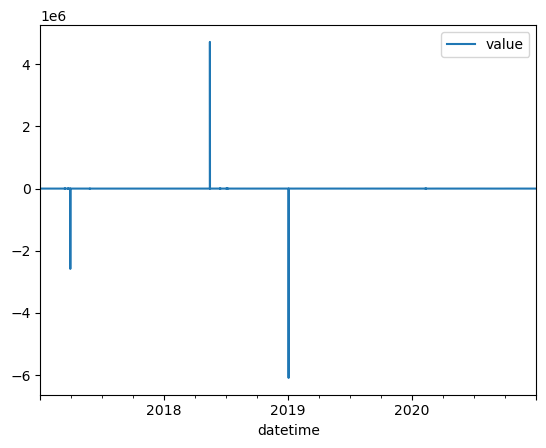

In [213]:
train_data.plot()

시각화해보니 눈에 띄게 이상한 값 3개 정도 보임
절대값이 10000 보다 크면 null 값으로 처리하자
null 값을 앞 뒤의 평균으로 보간 처리하자.

# [데이터 전처리]

In [214]:
# train_data의 'value'의 절대값이 10000보다 큰 행의 인덱스를 가져와서 train_data에 마스킹 연산
train_data[np.abs(train_data['value']) > 10000]

,value
datetime,
2017-03-30 16:00:00,-2584551.0
2018-05-15 20:00:00,4720655.0
2019-01-02 15:00:00,-6093821.0


해보니 세 곳이 값이 튄다.
null 처리하자.

In [215]:
# 거기에 Null 값 넣음
train_data[np.abs(train_data['value']) > 10000] = np.NaN

In [216]:
# 다시 확인
train_data[np.abs(train_data['value']) > 10000]

,value
datetime,


null 처리하고 다시 확인하니 이제 튀는 값 없다.
null로 준 값들을 보간처리하자.

In [217]:
# null 값을 보간처리함 ( interpolate() 메서드 기본값은 앞뒤로 평균처리 )
train_data = train_data.interpolate()

In [218]:
train_data

,value
datetime,
2017-01-01 01:00:00,138.0
2017-01-01 02:00:00,237.0
2017-01-01 03:00:00,128.0
2017-01-01 04:00:00,14.0
2017-01-01 05:00:00,11.0
...,...
2020-12-31 19:00:00,328.0
2020-12-31 20:00:00,347.0
2020-12-31 21:00:00,335.0


그래프로 시각화 하자.

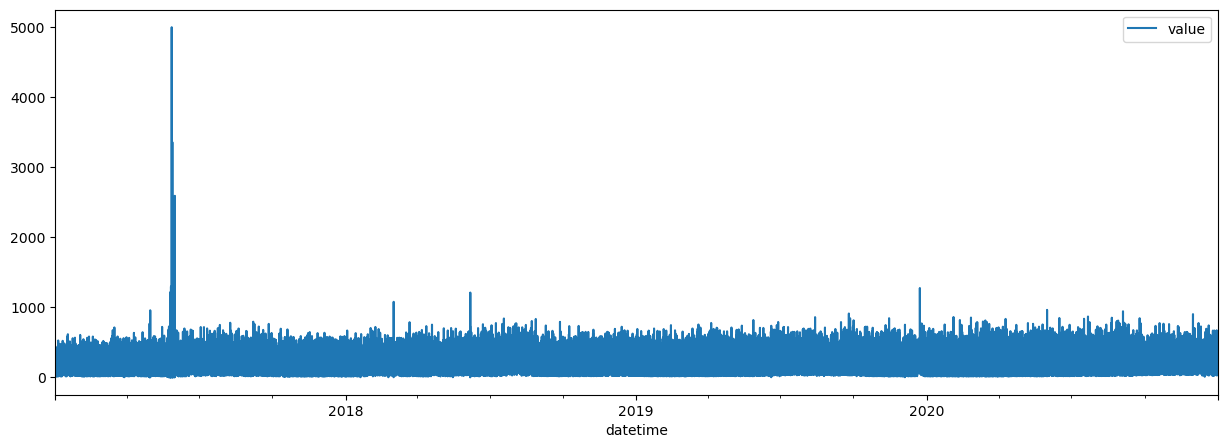

In [219]:
train_data.plot(figsize = (15, 5)) # 그래프 사이즈 조절
plt.show()

좀 더 자세히 시각화 해보고 싶으면 %matplotlib qt5 써서 matplotlib 설정 변경 (외부창에서 실행)
다시 안에서 보고 싶으면 %matplotlib inline 써서 설정 변경해줘야함 (내부창에서 실행)

In [220]:
%matplotlib qt5
train_data.plot(figsize = (15, 5))
plt.show()

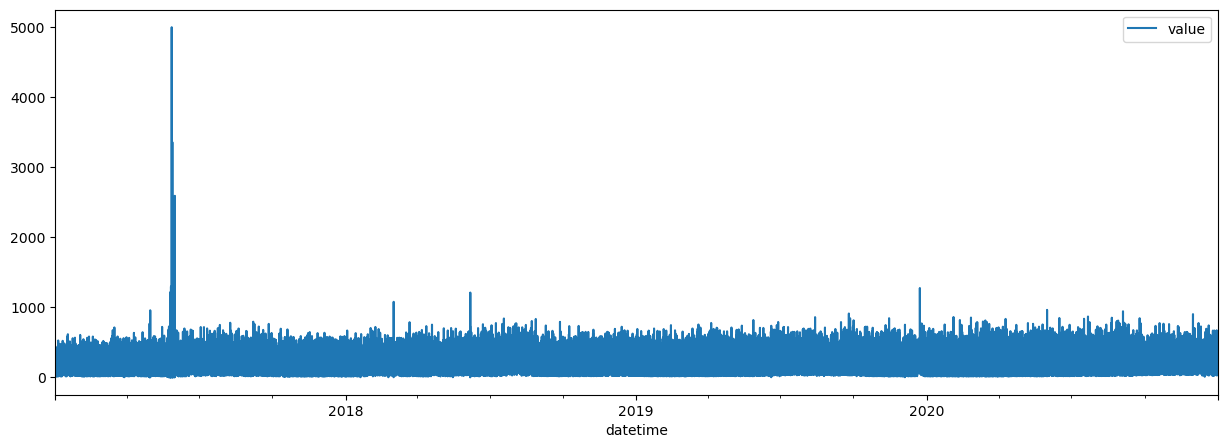

In [221]:
%matplotlib inline
train_data.plot(figsize = (15, 5))
plt.show()

시간 간격이 정말 모두 다 한시간 단위인가? 확인 해보자
3시간 간격 평균, 1일 간격 평균으로 리샘플링 (데이터에서 특정 간격으로 값을 가져옴)

In [222]:
train_data.resample("3H").mean() # 3시간 간격 평균

,value
datetime,
2017-01-01 00:00:00,187.500000
2017-01-01 03:00:00,51.000000
2017-01-01 06:00:00,69.333333
2017-01-01 09:00:00,249.666667
2017-01-01 12:00:00,211.333333
...,...
2020-12-31 09:00:00,418.666667
2020-12-31 12:00:00,285.000000
2020-12-31 15:00:00,310.333333


In [223]:
train_data.resample("1D").mean() # 1일 간격 평균

,value
datetime,
2017-01-01,167.086957
2017-01-02,181.000000
2017-01-03,192.500000
2017-01-04,181.958333
2017-01-05,173.166667
...,...
2020-12-27,233.750000
2020-12-28,242.166667
2020-12-29,249.541667


만약 1시간이 아니라면 1시간 동안의 평균값을 들고 올 수 없으므로 간격이 다른 곳은 null 값으로 변환됨.
is null 을 쓰면 null인 곳은 True로 반환됨
Ture를 다 더하면 1시간 간격이 아닌 곳이 있는지 없는지 알 수 있다.

In [224]:
train_data.resample("1H").mean().isnull().sum()

value    0
dtype: int64

적산차는 시간에 관련 있을 것 이므로, 시간에 대한 정보를 제공해야 함.
순환하는 값(시간, 날짜 등)은 코사인이나 사인 변환이 간단하고 좋음.
데이터의 값이 너무 크기때문에 값의 범위를 평균이 0, 분산이 1이 되도록 변경   <-- 정규분표로 만들어 보자.
## 값의 범위가 너무 크면 딥러닝 모델 학습이 불안정하기 때문.
## -> 사인파 ,코사인파, 정규분포 변환

In [225]:
# 값을 사인파로 변환
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

#값을 코사인파로 변환
def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [226]:
# datetime 칼럼을 train_data의 인덱스로 변경
train_data["datetime"] = train_data.index

# day_sin 칼럼을 만들고 거기에 datetime의 날짜 데이터를 365일 형식으로 가져오고 sin 변환
train_data["day_sin"] = sin_transformer(365).fit_transform(
    train_data["datetime"].dt.dayofyear
)

# hour_sin 칼럼을 만들고 거기에 datetime의 날짜 데이터를 24시간 형식으로 가져오고 sin 변환
train_data["hour_sin"] = sin_transformer(24).fit_transform(
    train_data["datetime"].dt.hour
)

# day_cos 칼럼을 만들고 거기에 datetime의 날짜 데이터를 365일 형식으로 가져오고 cos 변환
train_data["day_cos"] = cos_transformer(365).fit_transform(
    train_data["datetime"].dt.dayofyear
)

# hour_cos 칼럼을 만들고 거기에 datetime의 날짜 데이터를 24시간 형식으로 가져오고 cos 변환
train_data["hour_cos"] = cos_transformer(24).fit_transform(
    train_data["datetime"].dt.hour
)



# 정규분포로 변환시켜주는 스케일러
scaler = StandardScaler()

# 'value'칼럼 데이터의 평균과 분산을 구하고 ( StandardScaler.fit() 메서드)
scaler.fit(train_data['value'].values.reshape((-1, 1)))

# 'value'칼럼 데이터를 정규분포로 변환 ( StandardScaler.transform() 메서드 )
train_data['value'] = scaler.transform(train_data['value'].values.reshape((-1, 1)))
train_data

,value,datetime,day_sin,hour_sin,day_cos,hour_cos
datetime,,,,,,
2017-01-01 01:00:00,-0.596075,2017-01-01 01:00:00,0.017213,0.258819,0.999852,0.965926
2017-01-01 02:00:00,0.002208,2017-01-01 02:00:00,0.017213,0.500000,0.999852,0.866025
2017-01-01 03:00:00,-0.656508,2017-01-01 03:00:00,0.017213,0.707107,0.999852,0.707107
2017-01-01 04:00:00,-1.345441,2017-01-01 04:00:00,0.017213,0.866025,0.999852,0.500000
2017-01-01 05:00:00,-1.363570,2017-01-01 05:00:00,0.017213,0.965926,0.999852,0.258819
...,...,...,...,...,...,...
2020-12-31 19:00:00,0.552145,2020-12-31 19:00:00,0.017213,-0.965926,0.999852,0.258819
2020-12-31 20:00:00,0.666968,2020-12-31 20:00:00,0.017213,-0.866025,0.999852,0.500000
2020-12-31 21:00:00,0.594448,2020-12-31 21:00:00,0.017213,-0.707107,0.999852,0.707107


In [227]:
# datetime 칼럼 삭제
train_data = train_data.drop(columns="datetime")
train_data

,value,day_sin,hour_sin,day_cos,hour_cos
datetime,,,,,
2017-01-01 01:00:00,-0.596075,0.017213,0.258819,0.999852,0.965926
2017-01-01 02:00:00,0.002208,0.017213,0.500000,0.999852,0.866025
2017-01-01 03:00:00,-0.656508,0.017213,0.707107,0.999852,0.707107
2017-01-01 04:00:00,-1.345441,0.017213,0.866025,0.999852,0.500000
2017-01-01 05:00:00,-1.363570,0.017213,0.965926,0.999852,0.258819
...,...,...,...,...,...
2020-12-31 19:00:00,0.552145,0.017213,-0.965926,0.999852,0.258819
2020-12-31 20:00:00,0.666968,0.017213,-0.866025,0.999852,0.500000
2020-12-31 21:00:00,0.594448,0.017213,-0.707107,0.999852,0.707107


# [딥러닝 모델링에 넣기 위한 데이터 준비]

* 이 문제는 뭘 예측해야하는가?
* 이전 과거 데이터를 입력받아 미래의 336시간의 값을 예측해야함
* 입력 : 특정 길이만큼의 시계열 데이터 (길이를 가변으로 할 수 없음)
* 출력 : 336시간 만큼의 시계열 데이터

* 지금 데이터는 그냥 일렬로 쭉 늘어진 형태이므로 이를 변환해줘야함

* 슬라이딩 윈도우 활용
* 예로 들어 주식 데이터가 365일 있을 때 이 데이터를 10일치 입력하여 다음 2일치 예측한다고 가정
* 윈도우 크기가 10일이 됨

1번 데이터는 1일부터 10일이 입력이고 그 다음 11일, 12일이 출력 \
2번 데이터는 2일부터 11일이 입력이고 그 다음이 12일, 13일 출력 \
3번 데이터는 3일부터 12일이 입력이고 그 다음이 13일, 14일 출력 \
...

이런 식으로 형태를 변환해줘야함




* 일단 여기서는 입력 길이를 336 * 2로 설정
* 여기에 맞춰서 슬라이딩 윈도우 적용

In [228]:
data = [] # 변수 data 배열선언
window_size = 336 * 2

# tqdm은 진행률 표시 (process bar)

# 슬라이딩 윈도우를 길이가 100짜리인 시계열에 윈도우 크기 10을 적용하면
# 100 - 10 + 1 개의 데이터 개수가 나옴

for i in tqdm(range(len(train_data) - window_size + 1)):
    # 윈도우 크기만큼 데이터에서 가져옴
    # pandas 형식이지만 내부는 numpy 형식으로 돼있기때문에 .values로 numpy 형식으로 추출
    x = train_data.iloc[i : i + window_size].values.reshape((1, window_size, 5))
    data.append(x)


# data는 리스트 형식으로 돼있으니 이를 numpy 행렬 형식으로 변환해줘야함
# 여기서는 그냥 리스트를 하나로 병합하는 연산으로 위를 동시에 처리함
data = np.concatenate(data, axis=0)
print(data.shape)

  0%|          | 0/34392 [00:00<?, ?it/s]

(34392, 672, 5)


* 그러나 지금은 출력에 대해서도 데이터를 생성해야하기 때문에
* 슬라이딩 윈도우 크기를 출력 길이만큼 더 길게 해서 데이터 생성
* 그 후 입력 데이터와 출력 데이터로 분리

In [229]:
input_length = 336 * 2
output_length = 336

window_size = input_length + output_length

train = np.lib.stride_tricks.sliding_window_view(
    train_data.values, window_size, axis=0).transpose((0, 2, 1))

print(train.shape)

input_data = train[:, :input_length, :]
output_data = train[:, input_length:, 0]

print(input_data.shape, output_data.shape)

(34056, 1008, 5)
(34056, 672, 5) (34056, 336)


* 데이터를 학습 / 검증 / 테스트로 분리. 그러나 현재 테스트 데이터는 data_ts_city.csv로 이미 있으므로 굳이 훈련 데이터에서 분리할 필요 없음
* 검증 데이터를 써야 모델 과적합 유무를 알 수 있음
* 과적합 : 훈련 데이터에만 매우매우 잘 예측하는 것. 새로운 데이터가 들어오면 엉뚱하게 예측할 수 있음

In [230]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    input_data, output_data, test_size=0.1, shuffle=False
)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(30650, 672, 5) (3406, 672, 5) (30650, 336) (3406, 336)


# [딥러닝 모델설계]

In [231]:
def create_model(input_length=336 * 2, output_length=336):
    inputs = layers.Input((input_length, 5))
    x = layers.Flatten()(inputs)

    x = layers.Dense(256, activation="gelu")(x)
    x = layers.Dense(256, activation="gelu")(x)
    x = layers.Dense(output_length)(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=x)
    return model


model = create_model()
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 672, 5)]          0         
                                                                 
 flatten_7 (Flatten)         (None, 3360)              0         
                                                                 
 dense_21 (Dense)            (None, 256)               860416    
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dense_23 (Dense)            (None, 336)               86352     
                                                                 
Total params: 1,012,560
Trainable params: 1,012,560
Non-trainable params: 0
_________________________________________________________________


# [모델 학습]

In [232]:
# 모델 컴파일
# 손실함수로 회귀문제에서 사용되는 mean absolute error 사용. (정답 - 예측)의 절대값 평균
# optimzier로 Adam 사용

model.compile(
    loss=tf.keras.losses.mean_absolute_error, optimizer=tf.keras.optimizers.Adam(0.001)
)

In [233]:
history1 = model.fit(
    x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=50, batch_size=512
)

60/60 [==============================] - 1s 15ms/step - loss: 0.6238 - val_loss: 0.5516
Epoch 2/50
60/60 [==============================] - 1s 12ms/step - loss: 0.5680 - val_loss: 0.5415
Epoch 3/50
60/60 [==============================] - 1s 11ms/step - loss: 0.5596 - val_loss: 0.5372
Epoch 4/50
60/60 [==============================] - 1s 11ms/step - loss: 0.5536 - val_loss: 0.5292
Epoch 5/50
60/60 [==============================] - 1s 11ms/step - loss: 0.5493 - val_loss: 0.5276
Epoch 6/50
60/60 [==============================] - 1s 11ms/step - loss: 0.5457 - val_loss: 0.5244
Epoch 7/50
60/60 [==============================] - 1s 11ms/step - loss: 0.5435 - val_loss: 0.5242
Epoch 8/50
60/60 [==============================] - 1s 11ms/step - loss: 0.5412 - val_loss: 0.5234
Epoch 9/50
60/60 [==============================] - 1s 11ms/step - loss: 0.5390 - val_loss: 0.5229
Epoch 10/50
60/60 [==============================] - 1s 11ms/step - loss: 0.5373 - val_loss: 0.5218
Epoch 11/50
60/60 [=

* 훈련 데이터에 대한 손실은 계속 감소하지만
* 한번도 보지못한 검증 데이터에 대한 손실은 어느 순간부터 증가함 (과적합)
* early stop을 걸어줘서 validation loss가 증가하면 학습을 멈추게끔 설정

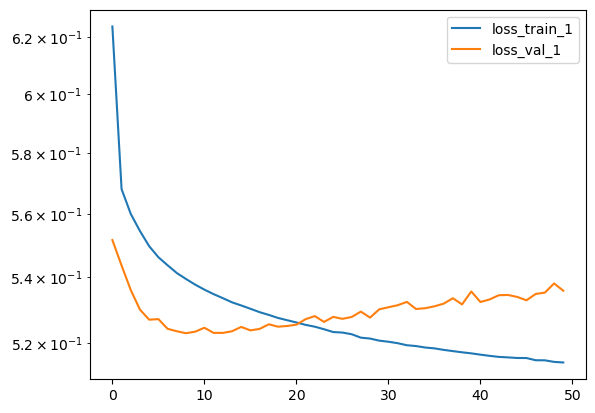

In [237]:
plt.plot(history1.history["loss"], label="loss_train_1")
plt.plot(history1.history["val_loss"], label="loss_val_1")
plt.legend()
plt.yscale("log")
plt.show()

In [238]:
model = create_model()
model.compile(
    loss=tf.keras.losses.mean_absolute_error, optimizer=tf.keras.optimizers.Adam(0.001)
)

# val loss가 증가하고 20번 동안 감소하지 않으면 학습 종료
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True, verbose=True
)

history2 = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=512,
    callbacks=[early_stop],
)

Epoch 1/100
60/60 [==============================] - 1s 15ms/step - loss: 0.6222 - val_loss: 0.5525
Epoch 2/100
60/60 [==============================] - 1s 12ms/step - loss: 0.5681 - val_loss: 0.5467
Epoch 3/100
60/60 [==============================] - 1s 12ms/step - loss: 0.5598 - val_loss: 0.5380
Epoch 4/100
60/60 [==============================] - 1s 13ms/step - loss: 0.5541 - val_loss: 0.5303
Epoch 5/100
60/60 [==============================] - 1s 14ms/step - loss: 0.5498 - val_loss: 0.5284
Epoch 6/100
60/60 [==============================] - 1s 13ms/step - loss: 0.5464 - val_loss: 0.5266
Epoch 7/100
60/60 [==============================] - 1s 12ms/step - loss: 0.5435 - val_loss: 0.5270
Epoch 8/100
60/60 [==============================] - 1s 12ms/step - loss: 0.5414 - val_loss: 0.5242
Epoch 9/100
60/60 [==============================] - 1s 12ms/step - loss: 0.5395 - val_loss: 0.5243
Epoch 10/100
60/60 [==============================] - 1s 12ms/step - loss: 0.5380 - val_loss: 0.5239

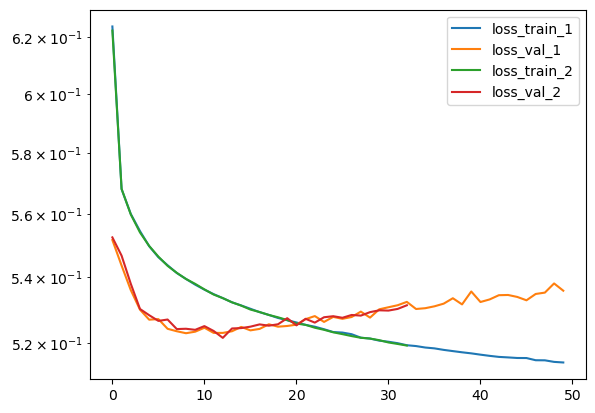

In [239]:
plt.plot(history1.history["loss"], label="loss_train_1")
plt.plot(history1.history["val_loss"], label="loss_val_1")
plt.plot(history2.history["loss"], label="loss_train_2")
plt.plot(history2.history["val_loss"], label="loss_val_2")
plt.legend()
plt.yscale("log")
plt.show()

In [240]:
# 제출할 예측 데이터 생성

# 테스트 데이터에 대해서도 똑같은 전처리 수행

test_data = pd.read_csv("data_ts_city.csv")

test_data.index = pd.to_datetime(test_data["datetime"], format="%Y-%m-%d %H:%M:%S")

test_data.columns = ["datetime", "value"]

test_data["datetime"] = pd.to_datetime(
    test_data["datetime"], format="%Y-%m-%d %H:%M:%S"
)

test_data["day_sin"] = sin_transformer(365).fit_transform(
    test_data["datetime"].dt.dayofyear
)

test_data["hour_sin"] = sin_transformer(24).fit_transform(test_data["datetime"].dt.hour)

test_data["day_cos"] = cos_transformer(365).fit_transform(
    test_data["datetime"].dt.dayofyear
)

test_data["hour_cos"] = cos_transformer(24).fit_transform(test_data["datetime"].dt.hour)

test_data['value'] = scaler.transform(test_data['value'].values.reshape((-1, 1)))

test_data = test_data.drop(columns="datetime")

# 현재 이 문제는 2020년도 12월 데이터가 있어야 21년도를 예측할 수 있다
# 일단 훈련 데이터랑 테스트 데이터랑 합쳐서 처리해 보자

data = pd.concat([train_data, test_data], axis=0)
data

,value,day_sin,hour_sin,day_cos,hour_cos
datetime,,,,,
2017-01-01 01:00:00,-0.596075,0.017213,0.258819,0.999852,0.965926
2017-01-01 02:00:00,0.002208,0.017213,0.500000,0.999852,0.866025
2017-01-01 03:00:00,-0.656508,0.017213,0.707107,0.999852,0.707107
2017-01-01 04:00:00,-1.345441,0.017213,0.866025,0.999852,0.500000
2017-01-01 05:00:00,-1.363570,0.017213,0.965926,0.999852,0.258819
...,...,...,...,...,...
2021-12-17 19:00:00,0.546102,-0.238673,-0.965926,0.971100,0.258819
2021-12-17 20:00:00,1.670150,-0.238673,-0.866025,0.971100,0.500000
2021-12-17 21:00:00,0.963088,-0.238673,-0.707107,0.971100,0.707107


In [241]:
x_test = np.lib.stride_tricks.sliding_window_view(
    data.iloc[-len(test_data) - input_length :].values, 336 * 2, axis=0
).transpose((0, 2, 1))

x_test.shape

(8425, 672, 5)

# [데이터 예측]

In [242]:
predict = model.predict(x_test)

264/264 [==============================] - 1s 3ms/step


In [243]:
predict = scaler.inverse_transform(predict.reshape((-1, 336)))

In [244]:
sample = pd.read_csv('sample_city.csv')
sample.iloc[:, 1:] = predict.reshape((-1, 336))
sample

,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
0,2021-01-01 00:00:00,248.086380,157.717117,137.979797,83.022705,56.384373,46.626347,75.759476,96.532806,130.647293,...,248.670044,216.596146,242.763474,224.519104,291.127960,318.017059,360.069916,344.086914,325.970520,287.699646
1,2021-01-01 01:00:00,148.560425,107.937683,106.049713,80.609604,70.252380,66.963333,122.151733,189.971329,238.032578,...,216.403412,201.914307,221.686722,232.306610,332.036469,388.967682,395.430817,301.884155,284.771637,202.632889
2,2021-01-01 02:00:00,87.910294,76.233856,74.257721,61.211796,73.407043,93.417419,156.704178,246.129349,262.026001,...,219.352737,229.471146,264.383118,322.459900,402.612244,417.716949,334.983643,235.858276,211.505966,137.277115
3,2021-01-01 03:00:00,101.527664,58.718357,72.085129,82.109467,129.346725,193.124863,259.366577,290.619659,288.841187,...,233.093109,280.759430,315.849915,365.046539,421.485321,381.462555,267.655121,181.160614,154.509781,103.966995
4,2021-01-01 04:00:00,67.334152,49.586613,85.616592,148.067642,231.308243,326.084412,341.685455,345.998962,307.809357,...,268.685394,341.475128,363.813385,371.623260,384.360077,293.048157,193.825958,120.927109,107.071320,67.663071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2021-12-17 20:00:00,424.300995,361.250122,285.338135,270.870392,210.857025,137.543472,48.062061,24.071720,24.619556,...,326.633942,291.246887,288.773590,282.363953,259.451019,228.915497,202.791382,240.482773,287.874451,380.736023
8421,2021-12-17 21:00:00,372.631134,294.526093,253.612991,215.586563,158.968216,77.416901,25.230183,25.125889,6.314091,...,342.973785,307.673889,276.383850,268.949127,254.403732,218.719437,255.891235,293.494995,376.182312,419.040833
8422,2021-12-17 22:00:00,306.103302,261.803101,192.138428,120.494804,48.919422,33.788425,8.796635,26.082783,3.666507,...,313.631378,288.637939,269.017181,238.090683,258.004181,237.506500,309.198578,347.190277,402.747955,355.162445
8423,2021-12-17 23:00:00,263.920013,222.509857,133.350510,72.699646,31.999989,16.504475,31.222462,34.390156,21.245472,...,278.107361,296.806000,274.479126,227.938629,274.349457,308.424683,372.761353,378.519104,398.400208,312.016876


In [247]:
sample.to_csv('submit_task1.csv', index = False)